# Working with CMIP6 data in the JASMIN Object Store
This Notebook describes how to set up a virtual environment and then work with CMIP6 data in the JASMIN Object Store (stored in Zarr format).

## Step 1: Import required packages

In [1]:
import xarray as xr
import intake
import intake_esm
import fsspec
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris
import iris.quickplot as qplt

## Step 2: read the CMIP6 Intake (ESM) catalog from github
We define a collection ("col") that can be searched/filtered for required datasets.

In [2]:
col_url = "https://raw.githubusercontent.com/cedadev/" \
          "cmip6-object-store/master/catalogs/ceda-zarr-cmip6.json"
col = intake.open_esm_datastore(col_url)

How many datasets are currently stored?

In [3]:
f'There are {len(col.df)} datasets'

'There are 62943 datasets'

## Step 3: Filter the catalog for historical and future data
In this example, we want to compare the surface temperature ("tas") from the
UKESM1-0-LL model, for a historical and future ("ssp585-bgc") scenario.

In [4]:
col

,unique
mip_era,2
activity_id,18
institution_id,36
source_id,80
experiment_id,181
member_id,985
table_id,10
variable_id,61
grid_label,5
version,490


In [5]:
cat = col.search(
    activity_id='HighResMIP',
    experiment_id='hist-1950',
    table_id='Amon',
    member_id='r1i1p1*',
    variable_id="zg"
)
cat.df
# cat.unique(['table_id'])

,mip_era,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,version,dcpp_start_year,time_range,zarr_path,nc_path
0,CMIP6,HighResMIP,MOHC,HadGEM3-GC31-HM,hist-1950,r1i1p1f1,Amon,zg,gn,v20180730,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/MOHC/HadGEM3...
1,CMIP6,HighResMIP,EC-Earth-Consortium,EC-Earth3P-HR,hist-1950,r1i1p2f1,Amon,zg,gr,v20181212,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/EC-Earth-Con...
2,CMIP6,HighResMIP,NERC,HadGEM3-GC31-HH,hist-1950,r1i1p1f1,Amon,zg,gn,v20180927,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/NERC/HadGEM3...
3,CMIP6,HighResMIP,MPI-M,MPI-ESM1-2-HR,hist-1950,r1i1p1f1,Amon,zg,gn,v20180606,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/MPI-M/MPI-ES...
4,CMIP6,HighResMIP,EC-Earth-Consortium,EC-Earth3P,hist-1950,r1i1p2f1,Amon,zg,gr,v20190314,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/EC-Earth-Con...
5,CMIP6,HighResMIP,CMCC,CMCC-CM2-HR4,hist-1950,r1i1p1f1,Amon,zg,gn,v20190105,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/CMCC/CMCC-CM...
6,CMIP6,HighResMIP,ECMWF,ECMWF-IFS-HR,hist-1950,r1i1p1f1,Amon,zg,gr,v20170915,NaN,NaN,http://cmip6-zarr-o.s3.jc.rl.ac.uk/CMIP6.HighR...,/badc/cmip6/data/CMIP6/HighResMIP/ECMWF/ECMWF-...


In [6]:
# Extract the single record subsets 
hadgem3_gc31_hh_cat = cat.search(source_id='HadGEM3-GC31-HH')


## Step 4: Convert to xarray datasets

Define a quick function to convert a catalog to an xarray `Dataset`.

In [7]:
def cat_to_ds(cat):
    zarr_path = cat.df['zarr_path'][0]
    fsmap = fsspec.get_mapper(zarr_path)
    return xr.open_zarr(fsmap, consolidated=True, use_cftime=True)

Extract the `tas` (surface air temperture) variable for the historical and future experiments.

In [8]:
cat_to_ds(hadgem3_gc31_hh_cat)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 768, lon: 1024, plev: 19, time: 780)
Coordinates:
  * lat        (lat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * lon        (lon) float64 0.1758 0.5273 0.8789 1.23 ... 359.1 359.5 359.8
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1950-01-16 00:00:00 ... 2014-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(5, 768, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(5, 1024, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(780, 2), meta=np.ndarray>
    zg         (time, plev, lat, lon) float32 dask.array<chunksize=(5, 19, 768, 1024), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.0
    NCO:                     4.7.3
    activity_id:             HighResMIP
    branch_method:           fixed historical forcing from 1950 was applied f...
    branch_time_in_child:    0.0
    branch_time_in_parent:   10800.0
    cmor_version:            3.2.4
    contact:                 enquiries@metoffice.gov.uk
    creation_date:           2018-09-18T09:40:46Z
    data_specs_version:      01.00.23
    end_year:                2014
    experiment:              coupled historical 1950-2014
    experiment_id:           hist-1950
    external_variables:      areacella
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NERC.HadGEM...
    grid:                    N512
    grid_label:              gn
    history:                 Tue Mar 24 15:22:11 2020: ncatted -a institution...
    initialization_index:    1
    institution:             Natural Environment Research Council, STFC-RAL, ...
    institution_id:          NERC
    license:                 CMIP6 model data produced by NERC is licensed un...
    min_number_yrs_per_sim:  65
    mip_era:                 CMIP6
    mo_runid:                u-ay652
    nominal_resolution:      50 km
    parent_activity_id:      HighResMIP
    parent_experiment_id:    spinup-1950
    parent_mip_era:          CMIP6
    parent_source_id:        HadGEM3-GC31-MH
    parent_time_units:       days since 1950-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    references:              Williams, K., et al: The Met Office Global Coupl...
    source:                  HadGEM3-GC31-HH (2016): \naerosol: UKCA-GLOMAP-m...
    source_id:               HadGEM3-GC31-HH
    source_type:             AOGCM
    start_year:              1950
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Amon
    table_info:              Creation Date:(12 July 2017) MD5:634e51339cd2119...
    tier:                    2
    title:                   HadGEM3-GC31-HH model output prepared for CMIP6
    tracking_id:             hdl:21.14100/3146ac1a-7e25-4fcf-9872-f90acb6c68d9
    variable_id:             zg
    variant_info:            none
    variant_label:           r1i1p1f1

In [9]:
cat_to_ds(hadgem3_gc31_hh_cat)['zg']

,Array,Chunk
Bytes,46.62 GB,298.84 MB
Shape,"(780, 19, 768, 1024)","(5, 19, 768, 1024)"
Count,157 Tasks,156 Chunks
Type,float32,numpy.ndarray


In [10]:
hadgem3_gc31_hh_zg = cat_to_ds(hadgem3_gc31_hh_cat)['zg']
hadgem3_gc31_hh_zg_500hpa = hadgem3_gc31_hh_zg[dict(time=slice(None, 1), plev=slice(5, 6))]
hadgem3_gc31_hh_zg_500hpa

<xarray.DataArray 'zg' (time: 1, plev: 1, lat: 768, lon: 1024)>
dask.array<getitem, shape=(1, 1, 768, 1024), dtype=float32, chunksize=(1, 1, 768, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * lon      (lon) float64 0.1758 0.5273 0.8789 1.23 ... 358.8 359.1 359.5 359.8
  * plev     (plev) float64 5e+04
  * time     (time) object 1950-01-16 00:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    history:        2018-09-18T09:40:46Z altered by CMOR: Inverted axis: plev.
    long_name:      Geopotential Height
    original_name:  mo: (stash: m01s30i297, blev: [1000.0, 925.0, 850.0, 700....
    standard_name:  geopotential_height
    units:          m

## Step 5: Plot

Actually, I'm not very good at xarray so quickly pop into Iris to plot

In [19]:
cube = cat_to_ds(hadgem3_gc31_hh_cat)['zg'].to_iris()
cube

<iris 'Cube' of geopotential_height / (m) (time: 780; air_pressure: 19; latitude: 768; longitude: 1024)>

In [20]:
cube.has_lazy_data()

True

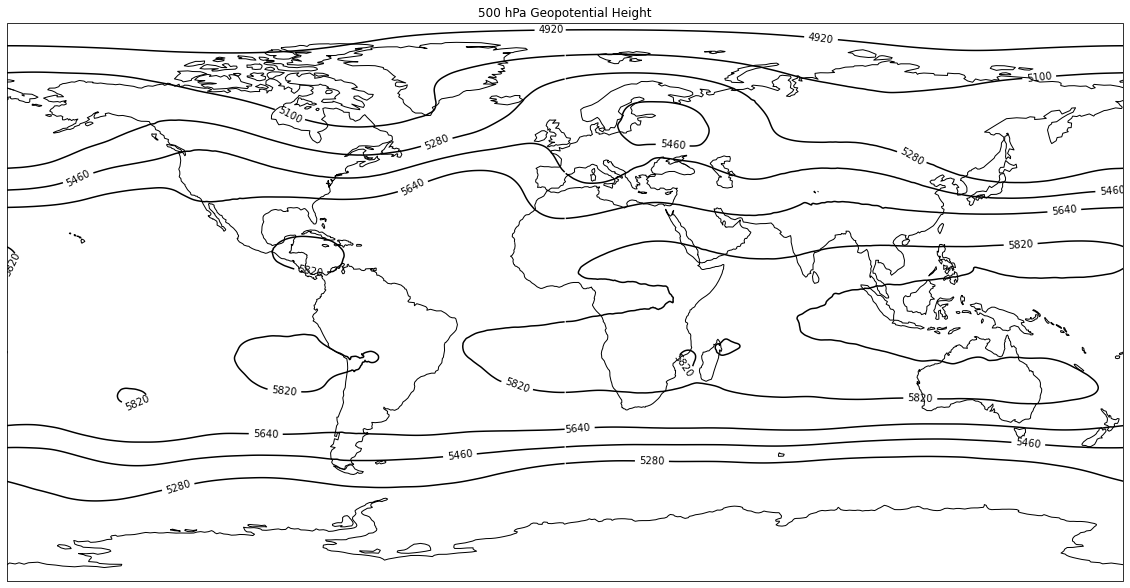

In [21]:
plt.figure(figsize=(20, 16))
cube = cube.extract(iris.Constraint(air_pressure=50000.))[0, ...]
CS = qplt.contour(cube, [4740, 4920, 5100, 5280, 5460, 5640, 5820, 6000, 6180, 6360], colors='k')
plt.gca().coastlines()
plt.gca().clabel(CS, inline=1, fontsize=10, fmt='%4.0f')
_t = plt.title('500 hPa Geopotential Height')

In [22]:
cube.has_lazy_data()

False

## References
- CMIP6 Object Store code (github): https://github.com/cedadev/cmip6-object-store
- This notebook: https://github.com/cedadev/cmip6-object-store/blob/master/notebooks/cmip6-zarr-jasmin.ipynb